<a href="https://colab.research.google.com/github/modichirag/galmodel/blob/u%2FEiffL%2FCosmicRIM/notebooks/CosmicRIM_TPU_eval_LBFGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies


In [1]:
!pip install git+https://github.com/modichirag/flowpm.git@u/EiffL/TPU
!git clone https://github.com/modichirag/flowpm.git
!git clone https://github.com/modichirag/galmodel.git -b u/EiffL/CosmicRIM

  Cloning https://github.com/modichirag/flowpm.git (to revision u/EiffL/TPU) to /tmp/pip-req-build-iczkssff
  Running command git clone -q https://github.com/modichirag/flowpm.git /tmp/pip-req-build-iczkssff
  Running command git checkout -b u/EiffL/TPU --track origin/u/EiffL/TPU
  Switched to a new branch 'u/EiffL/TPU'
  Branch 'u/EiffL/TPU' set up to track remote branch 'u/EiffL/TPU' from 'origin'.
  Created wheel for flowpm: filename=flowpm-0.1-cp36-none-any.whl size=11318 sha256=c933cda7a62f6d96b5ccec6891bcffcb2e87872d067a4e317143d0015db756a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-0v5db61_/wheels/7d/45/5d/c6ad7d04527b1275883565247915406a8f7c183ed65572eaf8
Successfully built flowpm
Cloning into 'flowpm'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 239 (delta 137), reused 153 (delta 62), pack-reused 0
Receiving objects: 100% (239/239), 156.19 KiB | 888.00 KiB/s, d

In [0]:
import sys
sys.path.insert(0,'galmodel/')

In [0]:
# Authenticate on GCP
from google.colab import auth
auth.authenticate_user() # Authenticates the backend and also the TPU using your credentials so that they can access your private GCS buckets

In [72]:
import tensorflow as tf
try: # TPU detection
  tpu = tf.contrib.cluster_resolver.TPUClusterResolver() # Picks up a connected TPU on Google's Colab, ML Engine, Kubernetes and Deep Learning VMs accessed through the 'ctpu up' utility
  #tpu = tf.contrib.cluster_resolver.TPUClusterResolver('MY_TPU_NAME') # If auto-detection does not work, you can pass the name of the TPU explicitly (tip: on a VM created with "ctpu up" the TPU has the same name as the VM)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  master = tpu.get_master()
  USE_TPU = True
except ValueError:
  tpu = None
  print("Running on GPU or CPU")
  USE_TPU = False

Running on GPU or CPU


In [0]:
BUCKET = 'gs://cosmic_rim' #@param {type:"string"}

## Moving on to the main business

In [75]:
%pylab inline
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

Populating the interactive namespace from numpy and matplotlib


In [0]:
import tensorflow as tf

import flowpm
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]

ipklin = iuspline(klin, plin)

### Build data pipeline

In [0]:
# Parameters of the simulations
a0 = 0.1
stages = np.linspace(a0, 1.0, 2, endpoint=True)
boxsize = 100
nc = 32
# Local batch size, the global batch size will be 8x that
batch_size = 2

def sample_sim(dummy):
  """ Draws a batch of realizations of initial cond
  """
  initial_conditions = flowpm.linear_field(nc, boxsize, ipklin, batch_size=batch_size)
  state = flowpm.lpt_init(initial_conditions, a0=a0)
  final_state = flowpm.nbody(state, stages, nc)
  final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
  # return features, labels
  return (tf.expand_dims(final_field, axis=-1), tf.expand_dims(initial_conditions, axis=-1)), tf.expand_dims(initial_conditions, axis=-1)

In [0]:
# Create the dataset input function
def input_fn(params):
  dset = tf.data.Dataset.range(100000)
  dset = dset.map(sample_sim)
  dset = dset.apply(tf.data.experimental.unbatch())
  dset = dset.batch(1, drop_remainder=True)
  return dset

## Build estimator

In [0]:
from galmodel.layers.recurrent_inference import ConvRIM3D
from galmodel.layers.convolutional_recurrent import ConvLSTM3DCell

def pm(lin):
  state = flowpm.lpt_init(lin, a0=a0)
  final_state = flowpm.nbody(state, stages, nc)
  final_field = flowpm.cic_paint(tf.zeros_like(lin), final_state[0])
  return final_field

def likelihood_fn(inputs, predictions):
  """ Evaluates the data likelihood function through Fast PM
  """
  final_field = pm(predictions[..., 0])
  likelihood = tf.reduce_mean((final_field - inputs[...,0])**2, 
                              axis=[1, 2, 3])
  return likelihood


def model_fn(features, labels, mode, params):
  """
  Model function for the CosmicRIM.
  """
  labels = features[1]
  features = features[0]
  is_training = mode == tf.estimator.ModeKeys.TRAIN
  
  # Build the RIM
  cell = ConvLSTM3DCell(filters=128, kernel_size=3, padding='SAME')
  output_layer = tf.keras.layers.Conv3D(filters=1, kernel_size=3, padding='SAME')
  
  cosmic_rim = ConvRIM3D(cell,
                       output_layer,
                       likelihood_fn=likelihood_fn,
                       niter=10, 
                       return_sequences=True)

  preds = cosmic_rim(features)
  predictions = {'preds':tf.transpose(preds, [1,0,2,3,4,5]), 
                 'fins':pm(preds[-1][...,0]),
                 'features': features,
                 'labels':labels}
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, 
                                      predictions=predictions)
  
  batch_loss = tf.reduce_mean((preds - labels)**2, axis=[0, 2, 3, 4, 5])

  loss = tf.reduce_mean(batch_loss)
  
  
  train_op = None
   
  learning_rate = tf.train.exponential_decay(0.001,
        tf.train.get_global_step(),
        decay_steps=100000,
        decay_rate=0.96)
  optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
  
  
  # Define optimizer
  if mode == tf.estimator.ModeKeys.TRAIN:
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      train_op = optimizer.minimize(loss=loss,
                                     global_step=tf.train.get_global_step())
    
  return tf.estimator.EstimatorSpec(mode=mode,
                                      loss=loss,
                                      train_op=train_op)

In [0]:
MODEL_DIR = BUCKET+"/rim/test3" 

In [94]:
config = tf.estimator.RunConfig(
    model_dir=MODEL_DIR,
    save_checkpoints_steps=500)

estimator = tf.estimator.Estimator(
    model_fn=model_fn,
    config=config
  )

INFO:tensorflow:Using config: {'_model_dir': 'gs://cosmic_rim/rim/test3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4d1a3a30b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
preds = estimator.predict(input_fn=input_fn, yield_single_examples=True)

In [113]:
res = next(preds)

INFO:tensorflow:Calling model_fn.
Tensor("conv_ri_m3d/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 1, 32, 32, 32, 128), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://cosmic_rim/rim/test3/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


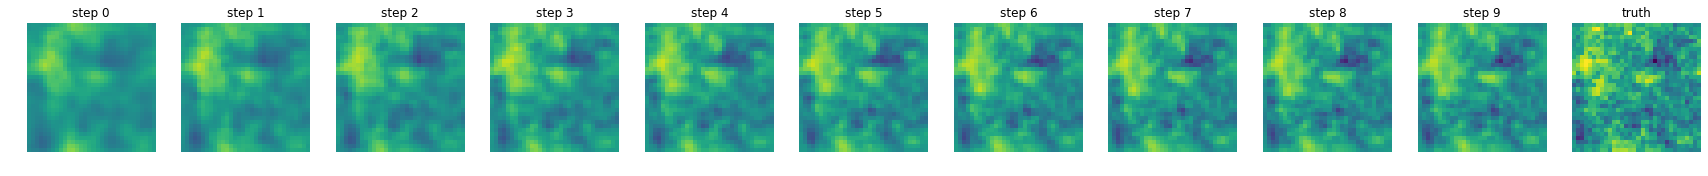

In [114]:
# This is for 10 iterations
ref = np.squeeze(res['labels']).sum(axis=0)

figure(figsize=(30,7))
for i in range(10):
  subplot(1,11,i+1)
  imshow(np.squeeze(res['preds'][i]).sum(axis=0), vmin=ref.min(), vmax=ref.max())
  axis('off')
  title('step %d'%i)

  subplot(1,11,11)
  imshow(ref, vmin=ref.min(), vmax=ref.max())
  title('truth')
  axis('off')

Text(0.5, 1.0, 'final field')

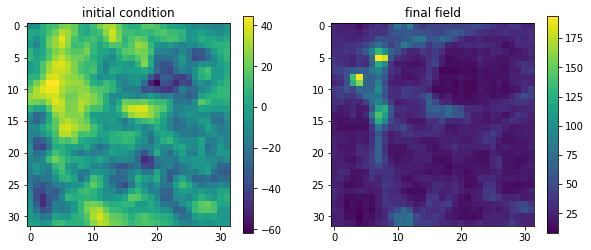

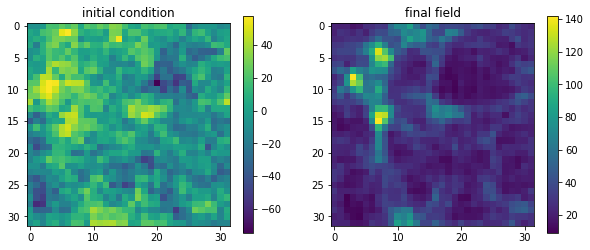

In [115]:
figure(figsize=(10,4))
subplot(121)
imshow(np.squeeze(res['preds'][-1]).sum(axis=0))
title('initial condition')

colorbar()
subplot(122)
imshow(np.squeeze(res['fins']).sum(axis=0))
colorbar()

title('final field')

figure(figsize=(10,4))
subplot(121)
imshow(np.squeeze(res['labels']).sum(axis=0))
colorbar()
title('initial condition')

subplot(122)
imshow(np.squeeze(res['features']).sum(axis=0))
colorbar()
title('final field')

In [0]:
preds.close()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


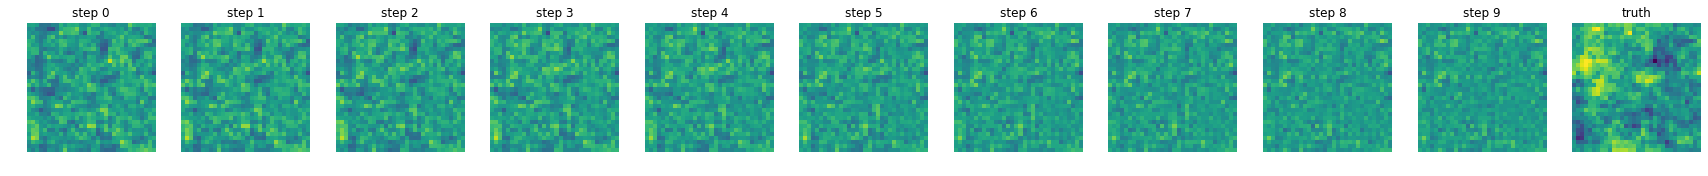

In [116]:
ref = np.squeeze(res['labels']).sum(axis=0)

l = []
figure(figsize=(30,7))
for i in range(10):
  subplot(1,11,i+1)
  imshow(np.squeeze(res['preds'][i] - res['labels']).sum(axis=0), vmin=ref.min(), vmax=ref.max())
  axis('off')
  title('step %d'%(i))
  l.append( sum((res['preds'][i] - res['labels'])**2))
  subplot(1,11,11)
  imshow(ref, vmin=ref.min(), vmax=ref.max())
  title('truth')
  axis('off')

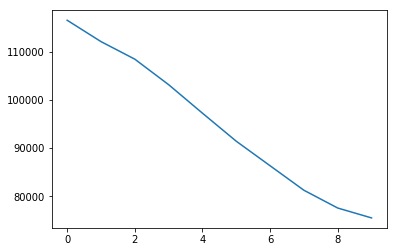

In [117]:
plot(l)

## Comparison to optimization

In [0]:
sys.path.append('galmodel/code/utils/')
sys.path.append('galmodel/code/flowpm/')

import tools

def makefig(truelin,truefin, linear, final, fname, boxsize, title=''):
    '''Given a graph, list of 3 fields in truemesh & recon-init                                                                                                                                                                   
    create the diagnostic figure,  3X3                                                                                                                                                                                            
    '''
    fig, ax = plt.subplots(2, 3, figsize = (8, 5))
    meshes = [[truelin, linear], [truefin, final]]
    labels = ['Linear', 'Final']
    for i in range(2):
        m1, m2 = meshes[i][0], meshes[i][1]
        if m1.mean() < 1e-2:
            m1, m2 = m1+1, m2+1
        k, pt = tools.power(m1, boxsize=boxsize)
        k, pr = tools.power(m2, boxsize=boxsize)
        k, px = tools.power(m1, m2, boxsize=boxsize)
        ax[0, 0].semilogx(k, px/(pr*pt)**.5, 'C%d'%i, label=labels[i])
        ax[1, 0].semilogx(k, pr/pt, 'C%d'%i)
#         ax[2+i].loglog(k, pt, 'C%d'%i)
#         ax[0, 2].loglog(k, pr, 'C%d--'%i)
        ax[0, 1+i].imshow(m2.sum(axis=0))
        ax[1, 1+i].imshow(m1.sum(axis=0))
    ax[1, 1].set_ylabel('Truth Linear', fontsize=12)
    ax[0, 1].set_ylabel('Recon Linear', fontsize=12)
    ax[1, 2].set_ylabel('Truth Final', fontsize=12)
    ax[0, 2].set_ylabel('Recon Final', fontsize=12)
    ax[0, 0].set_title('Cross Correlation', fontsize=12)
    ax[0, 0].set_ylim(-0.1, 1.1)
    ax[1, 0].set_title('Transfer Function', fontsize=12)
    ax[1, 0].set_ylim(-0.1, 2)
#     ax[0, 2].set_title('Powers')
#     ax[0, 2].set_ylim(1, 1e5)
    ax[0, 0].legend()
    for axis in ax.flatten(): axis.grid(which='both', lw=0.5, color='gray')
#     fig.suptitle(title)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
#     fig.savefig(fname)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


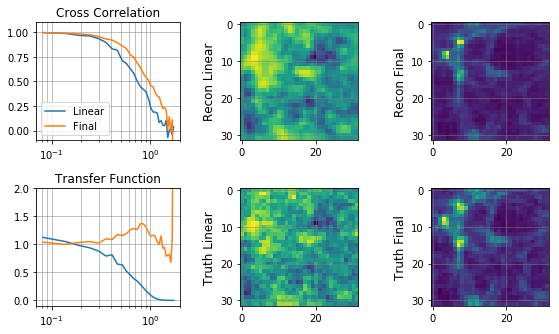

In [121]:
makefig(res['labels'][...,0], res['features'][...,0], res['preds'][-1][...,0], res['fins'], 'toto', 100)

In [122]:
from flowpm.kernels import fftk
kvec = fftk((nc, nc, nc), symmetric=False)
kmesh = sum((kk / boxsize * nc)**2 for kk in kvec)**0.5
pkmesh = ipklin(kmesh)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
from tensorflow.contrib.opt import ScipyOptimizerInterface

maxiter = 500
gtol=1e-5

sigma=1.0
tf.reset_default_graph()

def pm(lin):
  state = flowpm.lpt_init(lin, a0=a0)
  final_state = flowpm.nbody(state, stages, nc)
  final_field = flowpm.cic_paint(tf.zeros_like(lin), final_state[0])
  return final_field

xx = tf.placeholder(tf.float32, [1, nc, nc, nc])
yy = tf.placeholder(tf.float32, [1, nc, nc, nc])

linear = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
            initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
initlin_op = linear.assign(xx, name='initlin_op')

# Compute the likelihood fn
likelihood = likelihood_fn(tf.expand_dims(yy, -1), tf.expand_dims(linear,-1)) 

# Compute the prior
lineark = flowpm.utils.r2c3d(linear, norm=nc**3)
priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
prior = tf.reduce_mean(tf.multiply(priormesh, 1./pkmesh**2))*nc**3

logposterior = tf.reduce_mean(likelihood) +  tf.reduce_mean(prior)

opt = ScipyOptimizerInterface(logposterior, var_list=[linear], method='L-BFGS-B',
                                            options={'maxiter': maxiter, 'gtol':gtol})

final = pm(linear)

In [0]:
sess = tf.Session()    
sess.run(tf.global_variables_initializer())


batchsize = 1
# Initialize gradient descent at true point
#sess.run(initlin_op, {xx: res['labels'].reshape((1, nc,nc,nc))});

# Initialize gradient descent at pred point
sess.run(initlin_op, {xx: res['preds'][-1].reshape((1, nc,nc,nc))});

# Initialize gradient descent at final field
#sess.run(initlin_op, {xx: res['features'].reshape((1, nc,nc,nc))});

In [125]:
opt.minimize(sess, feed_dict={xx:res['labels'].reshape((1, nc,nc,nc)),
                              yy:res['features'].reshape((1, nc,nc,nc))} )

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.003638
  Number of iterations: 95
  Number of functions evaluations: 100


In [0]:
test, fins = sess.run([linear, final], {xx:res['labels'].reshape((1, nc,nc,nc)), 
                         yy:res['features'].reshape((1, nc,nc,nc))})

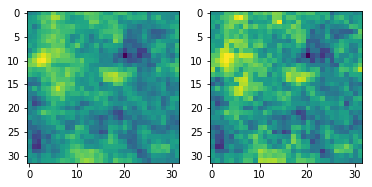

In [127]:
subplot(121)
plt.imshow(test[0].sum(axis=0));
subplot(122)
plt.imshow(res['labels'][:,:,:,0].sum(axis=0));

Text(0.5, 1.0, 'final field')

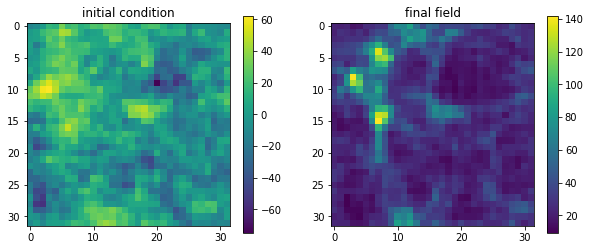

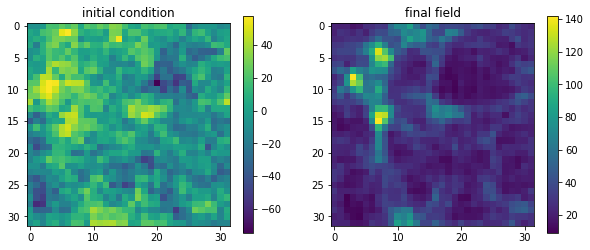

In [128]:
figure(figsize=(10,4))
subplot(121)
imshow(np.squeeze(test[0]).sum(axis=0))
title('initial condition')

colorbar()
subplot(122)
imshow(np.squeeze(fins).sum(axis=0))
colorbar()

title('final field')

figure(figsize=(10,4))
subplot(121)
imshow(np.squeeze(res['labels']).sum(axis=0))
colorbar()
title('initial condition')

subplot(122)
imshow(np.squeeze(res['features']).sum(axis=0))
colorbar()
title('final field')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


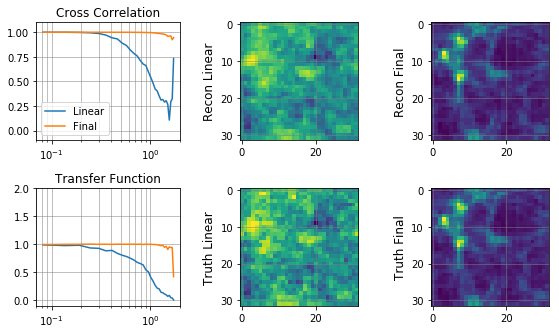

In [129]:
makefig(res['labels'][...,0], res['features'][...,0], test[0], fins[0], 'toto', 100)